# 이미지 데이터 살펴보기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ml-class-rhseung/data/recyclable_materials/'

In [ ]:
import os

os.listdir(path)

['plastic_bag', 'styrofoam', 'glass', 'can', 'paper', 'plastic']

In [ ]:
img_path = path + 'can/'
os.listdir(img_path)[0]

'IMG_8366.jpeg'

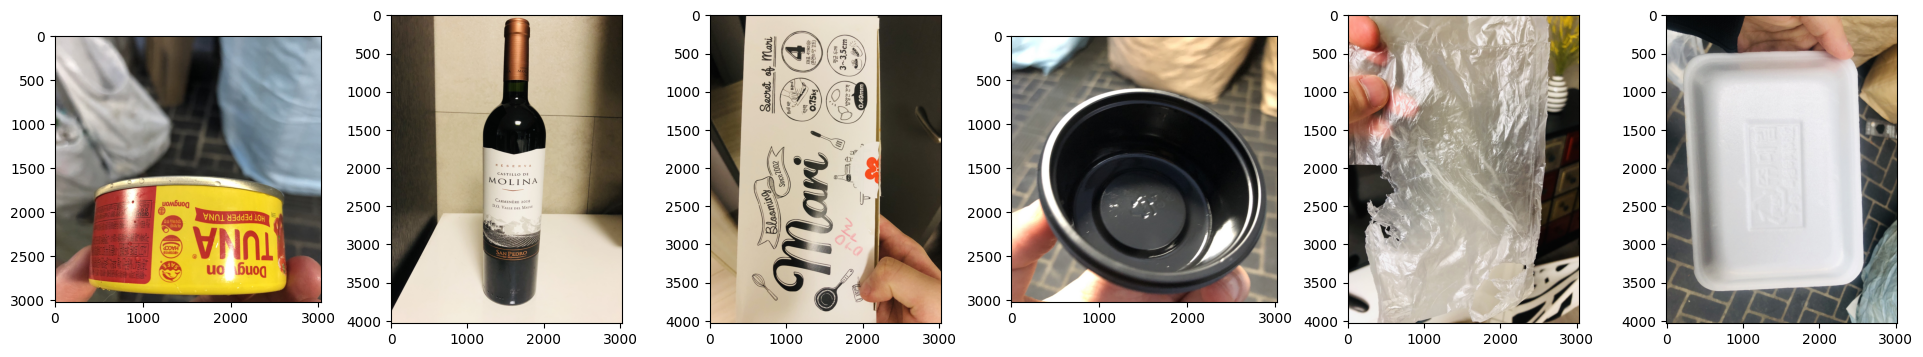

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

plt.figure(figsize=(24,4))
plt.tight_layout()
grid = gridspec.GridSpec(1,6)

class_names = ['can', 'glass', 'paper', 'plastic', 'plastic_bag', 'styrofoam']


for idx, label in enumerate(class_names):
    img_dir = f"{path}{label}/"
    img_path = img_dir + os.listdir(img_dir)[0]
    #print(img_path)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

# GPU 설정

In [ ]:
import torch
import numpy as np

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
device

device(type='cuda')

# 데이터 준비
* 이미지 폴더에서 데이터셋 만들기

In [ ]:
from torchvision import datasets
import torchvision.transforms as tr

path = '/content/drive/MyDrive/수업활동/2023_머신러닝과딥러닝/data/recyclable_materials/'

img_height = 32
img_width = 32

transf = tr.Compose([tr.Resize((img_height, img_width)),
                     tr.ToTensor(),
                     tr.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.ImageFolder(root=path, transform=transf)

In [ ]:
len(dataset)
dataset.classes
dataset.class_to_idx

{'can': 0,
 'glass': 1,
 'paper': 2,
 'plastic': 3,
 'plastic_bag': 4,
 'styrofoam': 5}

## 훈련 / 검증 / 테스트 데이터로 나누기

In [ ]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_size, validation_size, test_size

(213, 26, 28)

In [ ]:
from torch.utils.data.dataset import random_split

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

## 데이터 로더 만들기

In [ ]:
from torch.utils.data import DataLoader

batch_size =4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([4, 3, 32, 32])
torch.Size([4])


# 모델 생성

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=64*4*4, out_features=6)


    # 값 계산
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)


# 모델 학습

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, net, loss_fn, optimizer)
    test_loop(validation_dataloader, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.802090  [    0/  213]
loss: 1.774047  [   40/  213]
loss: 1.806391  [   80/  213]
loss: 1.742462  [  120/  213]
loss: 1.899222  [  160/  213]
loss: 1.750921  [  200/  213]
Test Error: 
 Accuracy: 42.3%, Avg loss: 1.646721 

Epoch 2
-------------------------------
loss: 1.642762  [    0/  213]
loss: 1.529259  [   40/  213]
loss: 1.819916  [   80/  213]
loss: 1.671026  [  120/  213]
loss: 1.545735  [  160/  213]
loss: 1.398115  [  200/  213]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.568870 

Epoch 3
-------------------------------
loss: 1.563935  [    0/  213]
loss: 1.918204  [   40/  213]
loss: 1.521941  [   80/  213]
loss: 1.136991  [  120/  213]
loss: 1.780797  [  160/  213]
loss: 1.686534  [  200/  213]
Test Error: 
 Accuracy: 23.1%, Avg loss: 1.525190 

Epoch 4
-------------------------------
loss: 1.063189  [    0/  213]
loss: 1.379232  [   40/  213]
loss: 1.781819  [   80/  213]
loss: 1.033859  [  120/  213]
loss: 1.410097  [  160/ 

In [ ]:
num_corr = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = net(images)
        preds = outputs.data.max(1)[1]
        corr = preds.eq(labels.to(device).data).sum().item()
        num_corr += corr

print(f"Accuracy : {num_corr/len(test_dataset)}")

Accuracy : 0.4642857142857143


In [ ]:
torch.save(net.state_dict(),"recycle.pt")

In [ ]:
#모델 객체 생성
from PIL import Image
net.load_state_dict(torch.load("recycle.pt", map_location=device))

image_path = "/content/IMG_8414.jpeg"
image = Image.open(image_path)

preprocessed_image = transf(image)
preprocessed_image = preprocessed_image.unsqueeze(0).to(device)
output = net(preprocessed_image)

In [ ]:
index = output.argmax().item()
dataset.classes[index]

'glass'

# 성능 개선


In [2]:
import torch
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/ml-class-rhseung/data/recyclable_materials/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

Mounted at /content/drive


device(type='cuda')

### 데이터 증강

In [ ]:
from torchvision import datasets
import torchvision.transforms as T
import numpy as np

원본 데이터는 `3024*3024`, `4032*3024` 등 해상도가 굉장히 높음

In [ ]:
tmp = datasets.ImageFolder(root=path, transform=T.Compose([T.ToTensor(), T.Resize((224, 224))]))
# imgs = np.array([v[0].numpy() for v in tmp])

# r = imgs[:, 0, :, :]
# g = imgs[:, 1, :, :]
# b = imgs[:, 2, :, :]

# channels = [r, g, b]
# mean = [x.mean() for x in channels]
# std = [x.std() for x in channels]

# mean, std

In [ ]:
mean, std = (0.58305043, 0.5538802, 0.5104812), (0.29039288, 0.27830067, 0.27818054)

transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.RandomCrop((224, 224), padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.Normalize(mean, std)
])

transform

Compose(
    ToTensor()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomCrop(size=(224, 224), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    Normalize(mean=(0.58305043, 0.5538802, 0.5104812), std=(0.29039288, 0.27830067, 0.27818054))
)

In [ ]:
from PIL import Image

classes = tmp.classes
X = []
Y = []

i = 0
for path, label in tmp.imgs:
    for _ in range(10):
        # `ToTensor()` 는 Image(32, 32, 3) 를 Tensor(3, 32, 32) 로 알아서 변환해서 transpose를 할 필요가 없다.
        X.append(transform(Image.open(path)).numpy())
        Y.append(label)

    print(i)
    i += 1

X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
1


In [ ]:
np.save('/content/drive/MyDrive/ml-class-rhseung/numpy/recycle_X', X)
np.save('/content/drive/MyDrive/ml-class-rhseung/numpy/recycle_Y', Y)

X.shape, Y.shape

(array([260.,   0., 560.,   0., 520.,   0., 810.,   0., 350., 170.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

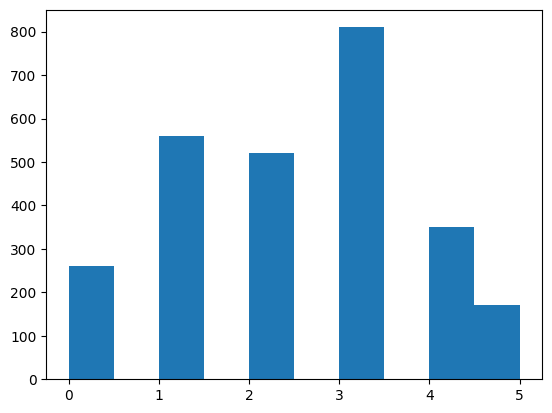

In [ ]:
import matplotlib.pyplot as plt

plt.hist(Y)

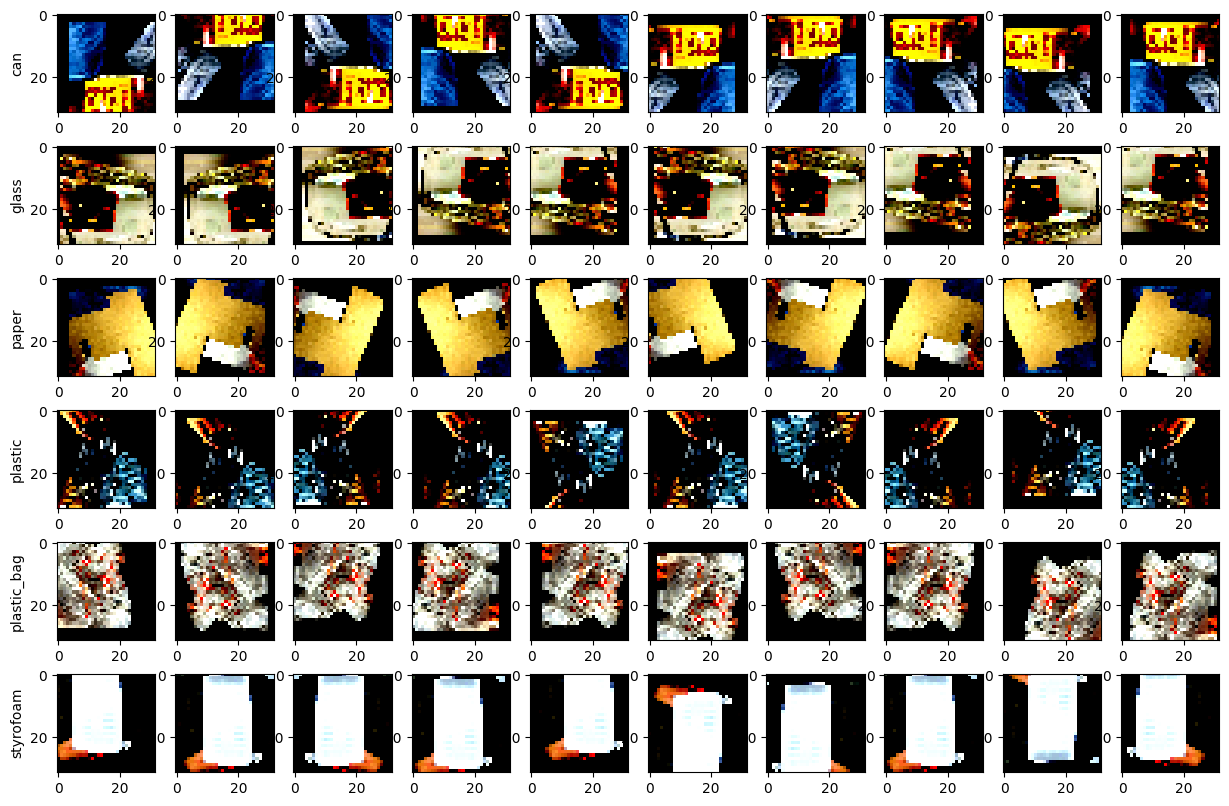

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(classes), 10, figsize=(15, 10))

for i in range(ax.shape[0]):
    ax[i, 0].set_ylabel(classes[i])
    indices = np.where(Y == i)[0]

    for j in range(ax.shape[1]):
        ax[i, j].imshow(X[indices[j]].transpose(1, 2, 0))

plt.show()

`Y`의 클래스 균등화

In [ ]:
# todo

### 모델 개선

In [3]:
import numpy as np
from os import listdir

X = np.load('/content/drive/MyDrive/ml-class-rhseung/numpy/recycle_X.npy')
Y = np.load('/content/drive/MyDrive/ml-class-rhseung/numpy/recycle_Y.npy')
classes = listdir(path)

X.shape, Y.shape, classes

((2670, 3, 32, 32),
 (2670,),
 ['glass', 'plastic_bag', 'can', 'paper', 'plastic', 'styrofoam'])

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_, Y_train, Y_ = train_test_split(X, Y, random_state=224, shuffle=True, test_size=0.2)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_, Y_, random_state=525, shuffle=True, test_size=0.5)

print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Y_valid

(2136, 3, 32, 32) (267, 3, 32, 32) (267, 3, 32, 32)
(2136,) (267,) (267,)


array([3, 1, 3, 3, 3, 3, 1, 5, 3, 4, 0, 3, 0, 3, 3, 3, 3, 1, 3, 1, 4, 1,
       2, 0, 2, 2, 2, 1, 3, 3, 3, 2, 3, 3, 0, 1, 1, 2, 4, 4, 1, 3, 3, 2,
       4, 3, 5, 1, 1, 4, 3, 3, 2, 3, 4, 2, 4, 1, 1, 3, 4, 3, 3, 0, 3, 3,
       2, 3, 2, 3, 3, 1, 1, 0, 3, 1, 3, 4, 3, 5, 4, 2, 3, 4, 2, 1, 2, 3,
       3, 3, 5, 2, 0, 2, 3, 2, 1, 3, 3, 4, 1, 0, 5, 5, 3, 0, 4, 4, 1, 5,
       2, 4, 1, 3, 1, 1, 0, 2, 3, 4, 1, 3, 4, 1, 1, 4, 1, 4, 1, 0, 2, 2,
       3, 1, 2, 1, 0, 2, 2, 4, 0, 2, 1, 4, 3, 1, 5, 4, 3, 3, 5, 5, 2, 3,
       0, 3, 1, 3, 1, 1, 3, 3, 3, 0, 0, 1, 2, 3, 3, 3, 4, 4, 1, 3, 3, 3,
       2, 4, 3, 2, 2, 3, 1, 2, 3, 1, 1, 2, 1, 1, 3, 0, 3, 2, 3, 3, 3, 2,
       5, 2, 1, 2, 2, 1, 1, 4, 3, 3, 3, 1, 3, 1, 3, 2, 1, 3, 3, 1, 2, 0,
       2, 1, 4, 0, 3, 1, 3, 1, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 3, 0, 3, 2,
       1, 3, 2, 4, 2, 5, 1, 2, 2, 0, 2, 3, 3, 1, 0, 5, 5, 5, 3, 1, 3, 3,
       1, 3, 3])

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset

class ImageDataset(Dataset):
    def __init__(self, X, Y, device='cpu'):
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.LongTensor(Y).to(device)

    def __len__(self) -> int:
        assert len(self.X) == len(self.Y)

        return len(self.Y)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.Y[idx]

train_dataset = ImageDataset(X_train, Y_train, device)
valid_dataset = ImageDataset(X_valid, Y_valid, device)
test_dataset = ImageDataset(X_test, Y_test, device)

len(train_dataset), len(valid_dataset), len(test_dataset)

(2136, 267, 267)

In [6]:
batch_size = 8

# shuffle은 train_test_split 에서 이미 함
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

In [7]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, hidden, end_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden, end_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layers = [
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.dropout,
            self.pool
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

class Net(nn.Module):
    def __init__(self, classes: list[str]):
        super().__init__()
        # super(Net, self).__init__()

        self.num_classes = len(classes)

        self.block1 = Block(3, 32, 64)          # (3, 32, 32) -> (64, 16, 16)
        self.block2 = Block(64, 96, 128)         # (64, 16, 16) -> (128, 8, 8)
        self.flatten = nn.Flatten(1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*8*8, 128)
        self.fc2 = nn.Linear(128, self.num_classes)

        self.layers = [
            self.block1,
            self.block2,
            self.flatten,
            self.fc1,
            self.relu,
            self.fc2
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [9]:
import torch.optim as optim
from torchsummary import summary
# from torchvision.models.vgg import vgg16

model = Net(classes).to(device)
# model = vgg16(pretrained=True).to(device)
# model.classifier = nn.Sequential(
#     nn.Linear()
# ).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
cost = nn.CrossEntropyLoss().to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
           Dropout-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
             Block-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 96, 16, 16]          55,392
              ReLU-9           [-1, 96, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         110,720
             ReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
        MaxPool2d-13            [-1, 128, 8, 8]               0
            Block-14            [-1, 12

In [10]:
from tqdm import tqdm
from dataclasses import dataclass
from math import inf

@dataclass
class Epoch:
    idx: int = None
    valid_loss: float = inf
    model_state: dict = None

before, curr = Epoch(), Epoch()
best = Epoch()

overfit_streak = 0
patience = 5

epochs = 100

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------')

    with tqdm(train_loader, unit='batch') as train:
        train.set_description("train")
        train_loss = 0

        for x, y in train:
            pred = model(x)
            loss = cost(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() / len(train)
            train.set_postfix(loss=train_loss)

    with torch.no_grad():
        with tqdm(valid_loader, unit='batch') as valid:
            valid.set_description("valid")
            valid_loss = 0

            for x, y in valid:
                pred = model(x)
                loss = cost(pred, y)

                valid_loss += loss.item() / len(valid)
                valid.set_postfix(loss=valid_loss)

    curr = Epoch(epoch, valid_loss, model.state_dict())

    if curr.valid_loss >= best.valid_loss:
        overfit_streak += 1
        print(f'overfit {overfit_streak}')
    else:
        overfit_streak = 0
        best = curr

    if patience <= overfit_streak:
        print(f"Early Stopping, best model is {best.idx + 1} epoch")
        break

    before = curr
    print()

torch.save(best.model_state, 'best_model.pth')

Epoch 1
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 270.87batch/s, loss=1.27]



Epoch 2
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 228.68batch/s, loss=1.1]



Epoch 3
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 216.73batch/s, loss=0.934]



Epoch 4
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 272.58batch/s, loss=0.855]



Epoch 5
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 286.23batch/s, loss=0.835]



Epoch 6
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 277.76batch/s, loss=0.795]



Epoch 7
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 266.91batch/s, loss=0.753]



Epoch 8
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 268.10batch/s, loss=0.821]


overfit 1

Epoch 9
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 295.12batch/s, loss=0.762]


overfit 2

Epoch 10
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 288.07batch/s, loss=0.752]



Epoch 11
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 241.01batch/s, loss=0.719]



Epoch 12
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 261.31batch/s, loss=0.763]


overfit 1

Epoch 13
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 269.83batch/s, loss=0.764]


overfit 2

Epoch 14
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 239.19batch/s, loss=0.69]



Epoch 15
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 278.04batch/s, loss=1.05]


overfit 1

Epoch 16
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 249.04batch/s, loss=0.879]


overfit 2

Epoch 17
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 280.69batch/s, loss=0.793]


overfit 3

Epoch 18
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 254.09batch/s, loss=0.796]


overfit 4

Epoch 19
-------------------------


valid: 100%|██████████| 33/33 [00:00<00:00, 252.77batch/s, loss=1.07]


overfit 5
Early Stopping, best model is 14 epoch


In [11]:
best.idx, best.valid_loss

(13, 0.6903997991572726)

In [12]:
model = Net(classes).to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))

if not isinstance(X_test, torch.Tensor):
    X_test = torch.FloatTensor(X_test).to(device)
    Y_test = torch.LongTensor(Y_test).to(device)

with torch.no_grad():
    output = model(X_test)
    pred = output.argmax(dim=1)
    is_correct = pred == Y_test

    print(f'Accuracy: {float(is_correct.float().mean())}')

Accuracy: 0.8089887499809265
